## Import necessary libraries

In [52]:
from __future__ import absolute_import, division, print_function

In [53]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import graphviz
from collections import Counter

In [54]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [55]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\mpfou\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [56]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [57]:
wn=nltk.WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words('english')) 
stop_words.add('yes')
stop_words.add('yeah')
stop_words.add('would')
stop_words.add('could')
stop_words.add('okay')
stop_words.add('also')
stop_words.add('ok')
stop_words.add('oh')
stop_words.add('th')
stop_words.add('alright')
stop_words.add('without')
stop_words.add('might')
stop_words.add('many')
stop_words.add('much')
stop_words.add('may')
stop_words.add('otherwise')

In [58]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'alright',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'could',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'many',
 'may',
 'me',
 'might',
 'mightn',
 "mightn't",
 'more',
 'most',
 'much',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'oh',
 'ok',
 'okay',
 'on',
 'on

## Getting the data to vectorize

In [71]:
data=pd.read_csv('CleanData.csv', encoding='utf-8')

In [72]:
print(data.head())

  Stakeholder     Asked by                                           Question  \
0  Anganwadi1          NaN                                                NaN   
1  Anganwadi1  Interviewer  That means there is one anganwadi for every 20...   
2  Anganwadi1  Interviewer            That means there are 26000 people here.   
3  Anganwadi1  Interviewer               That means this is a huge community.   
4  Anganwadi1  Interviewer  When we come from Gandhi Ashram, we have seen ...   

  Answered by                                             Answer  
0      Lady 1  We have 26 to 27 anganwadis from one corner to...  
1      Lady 1                                               Yes.  
2      Lady 1  Yes. That much is for sure, from one corner to...  
3      Lady 1  There is a lot in the interiors. How much ever...  
4      Lady 1  There is still a lot in the interiors. Till Ra...  


In [73]:
data=data.fillna('')

In [79]:
data.head()

,Stakeholder,Asked by,Question,Answered by,Answer
0,Anganwadi1,,,Lady 1,We have 26 to 27 anganwadis from one corner to...
1,Anganwadi1,Interviewer,That means there is one anganwadi for every 20...,Lady 1,Yes.
2,Anganwadi1,Interviewer,That means there are 26000 people here.,Lady 1,"Yes. That much is for sure, from one corner to..."
3,Anganwadi1,Interviewer,That means this is a huge community.,Lady 1,There is a lot in the interiors. How much ever...
4,Anganwadi1,Interviewer,"When we come from Gandhi Ashram, we have seen ...",Lady 1,There is still a lot in the interiors. Till Ra...


## Preparing the data

In [80]:
data['Combined']=data['Question']+' '+data['Answer']

In [14]:
data.loc[1]

Stakeholder                                           Anganwadi1
Asked by                                             Interviewer
Question       That means there is one anganwadi for every 20...
Answered by                                               Lady 1
Answer                                                      Yes.
Combined       That means there is one anganwadi for every 20...
Name: 1, dtype: object

In [15]:
combinedList=[]
for each in data['Combined']:
        if each is not np.nan:
            combinedList.append(each)

In [16]:
print(combinedList)

[' We have 26 to 27 anganwadis from one corner to another corner.', 'That means there is one anganwadi for every 200 houses? Yes.', 'That means there are 26000 people here. Yes. That much is for sure, from one corner to another corner there are that much.', 'That means this is a huge community. There is a lot in the interiors. How much ever population is there in the interior, that much is there in the exterior also.', 'When we come from Gandhi Ashram, we have seen some near the bridge and here. There is still a lot in the interiors. Till Ranip Crossing there is lot of them.', 'That means it covers the entire Vadaj Village and also the other side of Kitli ? No, that area is not included. It is there, but it is a different ward. For us it is from Juna Vadej to Ranip Crossroad. And in that entire belt we have our anganwadis.', 'Oh, that means lot of population is there. Yes, there is lot of population.', 'How many kids come here generally? What is your schedule for the whole day and what

## Function for data preprocessing and converting to tokens

In [8]:
def preprocess(text):
    text=re.sub("\\(.*?\\)","",text)
    word_tokens = nltk.word_tokenize(text) 
    pos=nltk.pos_tag(word_tokens)
    j=0
    for i,k in zip(pos[0:], pos[1:]):
        if ((i[1]=='NNP') & (k[1]=='NNP')):
            word_tokens[j]=i[0]+'-'
        j=j+1   
    text=' '.join(word_tokens)
    text=re.sub('- ','-',text)
    text=re.sub("-","",text)
    text = re.sub("[^a-zA-Z]"," ", text)
    word_tokens= nltk.word_tokenize(text)
    filtered_sentence = [] 
    for each in word_tokens:
        if(each.lower() not in stop_words):
            filtered_sentence.append(each)         
    text=[]        
    for word in filtered_sentence:
        if(word.endswith('ss')==False):
            temp=wn.lemmatize(word.lower())
            if(len(temp)>1):
                text.append(temp)
        else:
            text.append(word.lower())
    
    return text


def join(text):
    text=' '.join(text)
    return text

In [18]:
#sentence where each word is tokenized
dataToVectorize = []
for raw_response in combinedList:
    if len(raw_response) > 0:
        dataToVectorize.append(preprocess(raw_response))

In [19]:
print(dataToVectorize[0])
print(dataToVectorize[1])

['anganwadis', 'one', 'corner', 'another', 'corner']
['mean', 'one', 'anganwadi', 'every', 'house']


In [247]:
len(dataToVectorize)

6017

In [248]:
print(dataToVectorize)

[['anganwadis', 'one', 'corner', 'another', 'corner'], ['mean', 'one', 'anganwadi', 'every', 'house'], ['mean', 'people', 'sure', 'one', 'corner', 'another', 'corner'], ['mean', 'huge', 'community', 'lot', 'interior', 'ever', 'population', 'interior', 'exterior'], ['come', 'gandhiashram', 'seen', 'near', 'bridge', 'still', 'lot', 'interior', 'tillranipcrossing', 'lot'], ['mean', 'cover', 'entire', 'vadajvillage', 'side', 'kitli', 'area', 'included', 'different', 'ward', 'junavadej', 'ranipcrossroad', 'entire', 'belt', 'anganwadis'], ['mean', 'lot', 'population', 'lot', 'population'], ['kid', 'come', 'generally', 'schedule', 'whole', 'day', 'work', 'morning', 'come', 'kid', 'year', 'come', 'anganwadi', 'first', 'give', 'shira', 'rab', 'month', 'yearold', 'kid', 'cook', 'shira', 'rab', 'make', 'eat', 'kid', 'year', 'old', 'come', 'anganwadi', 'make', 'prayer', 'give', 'breakfast', 'matrumandal', 'monday', 'thursday', 'fruit', 'along', 'snack', 'menu', 'matrumandal', 'monday', 'saturday',

In [249]:
token_count = sum([len(response) for response in dataToVectorize])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 76,156 tokens


In [21]:
data['Data_clean']=data['Combined'].apply(preprocess).apply(join)

In [251]:
data.head()

,Stakeholder,Asked by,Question,Answered by,Answer,Combined,Data_clean
0,Anganwadi1,,,Lady 1,We have 26 to 27 anganwadis from one corner to...,We have 26 to 27 anganwadis from one corner t...,anganwadis one corner another corner
1,Anganwadi1,Interviewer,That means there is one anganwadi for every 20...,Lady 1,Yes.,That means there is one anganwadi for every 20...,mean one anganwadi every house
2,Anganwadi1,Interviewer,That means there are 26000 people here.,Lady 1,"Yes. That much is for sure, from one corner to...",That means there are 26000 people here. Yes. T...,mean people sure one corner another corner
3,Anganwadi1,Interviewer,That means this is a huge community.,Lady 1,There is a lot in the interiors. How much ever...,That means this is a huge community. There is ...,mean huge community lot interior ever populati...
4,Anganwadi1,Interviewer,"When we come from Gandhi Ashram, we have seen ...",Lady 1,There is still a lot in the interiors. Till Ra...,"When we come from Gandhi Ashram, we have seen ...",come gandhiashram seen near bridge still lot i...


## Creating the Word2Vec Model

In [252]:
#3 main tasks that vectors help with are DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, then faster we can train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [253]:
response2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

C:\Users\mpfou\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [254]:
response2vec.build_vocab(dataToVectorize)

2019-08-01 11:58:01,596 : INFO : collecting all words and their counts
2019-08-01 11:58:01,597 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-08-01 11:58:01,608 : INFO : collected 4094 word types from a corpus of 76156 raw words and 6017 sentences
2019-08-01 11:58:01,609 : INFO : Loading a fresh vocabulary
2019-08-01 11:58:01,613 : INFO : effective_min_count=3 retains 2102 unique words (51% of original 4094, drops 1992)
2019-08-01 11:58:01,614 : INFO : effective_min_count=3 leaves 73591 word corpus (96% of original 76156, drops 2565)
2019-08-01 11:58:01,620 : INFO : deleting the raw counts dictionary of 4094 items
2019-08-01 11:58:01,620 : INFO : sample=0.001 downsamples 75 most-common words
2019-08-01 11:58:01,621 : INFO : downsampling leaves estimated 59575 word corpus (81.0% of prior 73591)
2019-08-01 11:58:01,625 : INFO : estimated required memory for 2102 words and 300 dimensions: 6095800 bytes
2019-08-01 11:58:01,625 : INFO : resetting layer weigh

In [255]:
print("Word2Vec vocabulary length:", len(response2vec.wv.vocab))

Word2Vec vocabulary length: 2102


In [256]:
print(response2vec.wv.vocab)

{'anganwadis': <gensim.models.keyedvectors.Vocab object at 0x00000240994B13C8>, 'one': <gensim.models.keyedvectors.Vocab object at 0x00000240994B1A90>, 'corner': <gensim.models.keyedvectors.Vocab object at 0x00000240994B1518>, 'another': <gensim.models.keyedvectors.Vocab object at 0x00000240994B18D0>, 'mean': <gensim.models.keyedvectors.Vocab object at 0x00000240994B1EF0>, 'anganwadi': <gensim.models.keyedvectors.Vocab object at 0x00000240994B1588>, 'every': <gensim.models.keyedvectors.Vocab object at 0x00000240994B1D30>, 'house': <gensim.models.keyedvectors.Vocab object at 0x00000240994B15C0>, 'people': <gensim.models.keyedvectors.Vocab object at 0x00000240994B15F8>, 'sure': <gensim.models.keyedvectors.Vocab object at 0x00000240994B1630>, 'community': <gensim.models.keyedvectors.Vocab object at 0x00000240994B1668>, 'lot': <gensim.models.keyedvectors.Vocab object at 0x00000240994B16A0>, 'interior': <gensim.models.keyedvectors.Vocab object at 0x00000240994B1748>, 'ever': <gensim.models.

In [257]:
response2vec.train(dataToVectorize,total_examples=response2vec.corpus_count,epochs=20)

2019-08-01 11:58:01,688 : INFO : training model with 8 workers on 2102 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-08-01 12:00:40,792 : INFO : EPOCH 1 - PROGRESS: at 12.63% examples, 31 words/s, in_qsize 7, out_qsize 1
2019-08-01 12:00:40,793 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-08-01 12:02:13,801 : INFO : EPOCH 1 - PROGRESS: at 31.56% examples, 51 words/s, in_qsize 6, out_qsize 1
2019-08-01 12:02:13,805 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-08-01 12:02:16,330 : INFO : EPOCH 1 - PROGRESS: at 47.30% examples, 81 words/s, in_qsize 5, out_qsize 1
2019-08-01 12:02:16,334 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-08-01 12:02:27,718 : INFO : EPOCH 1 - PROGRESS: at 59.37% examples, 107 words/s, in_qsize 4, out_qsize 1
2019-08-01 12:02:27,721 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-08-01 12:02:27,796 : INFO : worker thread fin

2019-08-01 12:23:00,255 : INFO : EPOCH 6 - PROGRESS: at 47.30% examples, 89 words/s, in_qsize 5, out_qsize 1
2019-08-01 12:23:00,257 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-08-01 12:23:11,043 : INFO : EPOCH 6 - PROGRESS: at 58.72% examples, 117 words/s, in_qsize 4, out_qsize 1
2019-08-01 12:23:11,045 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-08-01 12:23:11,813 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-08-01 12:23:14,657 : INFO : EPOCH 6 - PROGRESS: at 81.59% examples, 179 words/s, in_qsize 2, out_qsize 1
2019-08-01 12:23:14,660 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-08-01 12:23:15,539 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-08-01 12:23:15,544 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-08-01 12:23:15,545 : INFO : EPOCH - 6 : training on 76156 raw words (59580 effective words) took 246.4s, 242 effective w

2019-08-01 12:43:54,663 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-08-01 12:43:56,338 : INFO : EPOCH 11 - PROGRESS: at 92.09% examples, 211 words/s, in_qsize 1, out_qsize 1
2019-08-01 12:43:56,341 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-08-01 12:43:56,716 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-08-01 12:43:56,717 : INFO : EPOCH - 11 : training on 76156 raw words (59535 effective words) took 246.0s, 242 effective words/s
2019-08-01 12:46:19,336 : INFO : EPOCH 12 - PROGRESS: at 12.63% examples, 35 words/s, in_qsize 7, out_qsize 1
2019-08-01 12:46:19,345 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-08-01 12:47:35,127 : INFO : EPOCH 12 - PROGRESS: at 31.56% examples, 59 words/s, in_qsize 6, out_qsize 1
2019-08-01 12:47:35,131 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-08-01 12:47:45,478 : INFO : EPOCH 12 - PROGRESS: at 47.30% examples, 90 word

2019-08-01 13:07:50,529 : INFO : EPOCH 17 - PROGRESS: at 31.56% examples, 60 words/s, in_qsize 6, out_qsize 1
2019-08-01 13:07:50,531 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-08-01 13:07:56,622 : INFO : EPOCH 17 - PROGRESS: at 47.30% examples, 94 words/s, in_qsize 5, out_qsize 1
2019-08-01 13:07:56,626 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-08-01 13:08:08,537 : INFO : EPOCH 17 - PROGRESS: at 59.37% examples, 123 words/s, in_qsize 4, out_qsize 1
2019-08-01 13:08:08,538 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-08-01 13:08:13,240 : INFO : EPOCH 17 - PROGRESS: at 70.78% examples, 153 words/s, in_qsize 3, out_qsize 1
2019-08-01 13:08:13,243 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-08-01 13:08:13,442 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-08-01 13:08:13,780 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-08-01 1

(1191236, 1523120)

## Saving the created model

In [258]:
if not os.path.exists("trained300D20"):
    os.makedirs("trained300D20")

In [259]:
 response2vec.save(os.path.join("trained300D20", "response2vec300D20.w2v"))

2019-08-01 13:19:25,540 : INFO : saving Word2Vec object under trained300D20\response2vec300D20.w2v, separately None
2019-08-01 13:19:25,542 : INFO : not storing attribute vectors_norm
2019-08-01 13:19:25,543 : INFO : not storing attribute cum_table
C:\Users\mpfou\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-08-01 13:19:25,632 : INFO : saved trained300D20\response2vec300D20.w2v


## Load the saved model

In [59]:
response2vec = w2v.Word2Vec.load(os.path.join("trained300D20", "response2vec300D20.w2v"))

2019-08-09 22:10:27,038 : INFO : loading Word2Vec object from trained300D20\response2vec300D20.w2v
C:\Users\mpfou\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-08-09 22:10:27,140 : INFO : loading wv recursively from trained300D20\response2vec300D20.w2v.wv.* with mmap=None
2019-08-09 22:10:27,144 : INFO : setting ignored attribute vectors_norm to None
2019-08-09 22:10:27,160 : INFO : loading vocabulary recursively from trained300D20\response2vec300D20.w2v.vocabulary.* with mmap=None
2019-08-09 22:10:27,161 : INFO : loading trainables recursively from trained300D20\response2vec300D20.w2v.trainables.* with mmap=None
2019-08-09 22:10:27,162 : INFO : setting ignored attribute cum_table to None


## Showing some example vectors

In [60]:
print(response2vec['anganwadis'])

[-8.06620419e-02  2.18170628e-01 -2.36572817e-01  7.68822059e-02
  2.53732979e-01  1.01782493e-01 -1.54932618e-01  4.39377010e-01
  3.39261115e-01  1.08182833e-01  2.29594126e-01  5.02005743e-04
 -2.23555490e-01  3.99395712e-02  2.41277605e-01 -2.16289848e-01
 -9.45569649e-02 -9.53992531e-02  3.22683692e-01  1.61404256e-02
  2.01622307e-01 -1.41242728e-01 -3.06717426e-01  1.89698592e-01
  2.06155270e-01  8.95638019e-03  3.36827524e-02 -5.40797487e-02
 -6.73466697e-02 -1.89270914e-01  1.50814271e-02 -2.74733722e-01
 -1.64914995e-01  1.22227035e-01  2.85781801e-01 -1.34337232e-01
 -3.23328793e-01  2.43320823e-01  1.15940601e-01  3.01627278e-01
 -1.42040346e-02  5.15672192e-02  6.93115816e-02 -2.05985501e-01
  2.90147573e-01 -2.01099813e-02  2.38269821e-01  1.96252316e-01
 -1.76790625e-01  5.46019673e-02 -4.69618291e-02 -3.34737360e-01
  2.06229519e-02 -9.68523696e-02  1.87574387e-01  4.85825129e-02
 -2.34341063e-02 -1.11398108e-01  3.84322107e-02 -2.49764234e-01
  1.47749379e-01 -8.33904

C:\Users\mpfou\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


## Finding the most similar words

Let us drill down into the data to find the details about fuel, food, disease, language, electronic devices, work.

<b>Fuel:

In [134]:
response2vec.most_similar("fuel")

C:\Users\mpfou\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('primus', 0.9716500639915466),
 ('chula', 0.9446691274642944),
 ('lpg', 0.9272397756576538),
 ('kerosene', 0.9151356220245361),
 ('sigdi', 0.895534873008728),
 ('piece', 0.8855994939804077),
 ('winter', 0.8605989813804626),
 ('gas', 0.8334647417068481),
 ('cylinder', 0.7889919281005859),
 ('plain', 0.7841489315032959)]

<b>Evaluating the above result:

In [82]:
temp=data[data['Combined'].str.contains('fuel')]
text=[]
for ans in temp['Answer']:
    text.append(ans)
print(text)    

['They use gas and Chula', 'Many use primus, many use Chula and now a days in many houses gas connection has also come.', 'They all have LPG, but they use it less so that the cylinder run for 2 to 3 months. They also use kerosene, as they get kerosene using their BPL card. Those who don’t get kerosene will use Chula also. They bring wood pieces and cook on Chula.', 'Gas cylinder.']


<b>Food:

In [83]:
response2vec.most_similar("food")

C:\Users\mpfou\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('tasty', 0.6863527297973633),
 ('oily', 0.6767541170120239),
 ('hygienic', 0.6679632067680359),
 ('cleanliness', 0.6613503694534302),
 ('fried', 0.6441251039505005),
 ('item', 0.632609486579895),
 ('wholesome', 0.6213387250900269),
 ('cooked', 0.6055780649185181),
 ('spice', 0.602304220199585),
 ('vegetarian', 0.6014676094055176)]

<b>Evaluating the result:

In [97]:
temp=data[data['Combined'].str.contains('food')]
text=[]
for ans in temp['Answer']:
    text.append(ans)
print(text) 

['The problem here is mothers don’t have time to take care of kids. So what they do is they give one rupee in hands of kids, because they want to go out for work or do household work. So what they do is they give one rupee to kids and kids buy those one rupee packet of Mamri and Bhungla and eat it. They are very dangerous and the colors used in that are very harmful. Because of that the kids do not get nutrition. Also they eat pepsi, etc. Mothers don’t have time to cook food and feed them. Because of that kids remain malnutritional. They have lot of superstitions like if a child fall sick, they would go to the Bhuva and do Dhora Dhaga, and will not take them to dispensary. Therefore this malnutriotion is seen at high rate in the kids. Because of anganwadi there has come lot of difference. They have came out little from these superstitions and understood that if a child fall sick or if we fall sick, we should take them to dispensary. When we say them, they become immediately ready.', 'F

<b>Language:

In [23]:
response2vec.most_similar("language")

C:\Users\mpfou\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-08-02 11:40:22,288 : INFO : precomputing L2-norms of word weight vectors


[('foul', 0.8195366859436035),
 ('hindi', 0.7646679878234863),
 ('gujarati', 0.7471677660942078),
 ('frank', 0.7457628846168518),
 ('speaks', 0.70599764585495),
 ('speaking', 0.704619288444519),
 ('dialect', 0.7013141512870789),
 ('reading', 0.6836669445037842),
 ('vocal', 0.6691027879714966),
 ('poha', 0.6682119965553284)]

<b>Evaluating the result:

In [110]:
temp=data[data['Combined'].str.contains('language')]
text=[]
for ans in temp['Answer']:
    text.append(ans)
print(text) 

['Hardly any boys go for studying, many boys just roam about. Lot of foul language is spoken in the house. So right from childhood kids also get influenced by this and there is 100 percent chance that they go on wrong path.', 'No, nobody has the feeling that my son is doing something wrong and so I should correct, like how do we take care when it is our child. Now it is like go and do what you want to do. Even to their parents they speak dirty foul language which we can’t even listen to. But parents would not ask them about why you are talking this kind of language.', 'Yes, within themselves. Siblings and parents keeps fighting by speaking foul languages to each other. For them fighting means speaking bad languages to each other. They don’t fight normally. They speak lot of foul languages.', 'They know all the languages, but rough language.', 'Not like that, only Gujarati and Hindi we can see. First of all mostly here are Gujarati only, nobody is Hindi.', 'They keep Hindi as their lang

<b>Work:

In [24]:
response2vec.most_similar("work")

C:\Users\mpfou\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bungalow', 0.6556487083435059),
 ('mason', 0.6349966526031494),
 ('masonry', 0.6130069494247437),
 ('maid', 0.6075021624565125),
 ('construction', 0.6050369739532471),
 ('electrical', 0.6028178930282593),
 ('selfemployment', 0.5999700427055359),
 ('ride', 0.5870542526245117),
 ('floor', 0.5800060629844666),
 ('contract', 0.5795734524726868)]

<b>Evaluating the result:

In [108]:
temp=data[data['Combined'].str.contains('work')]
text=[]
for ans in temp['Answer']:
    text.append(ans)
print(text) 

['At morning when we come, kids of 3 to 6 years come to our anganwadi. First, we have to give Shira and Rab to 6 months to 3-year-old kids. So, we cook Shira and Rab and make them eat. After that kids of 3 to 6 years old come to our anganwadi. We make them do prayers. Then we have to give them breakfast of Matru Mandal. On Monday and Thursday we have fruits along with snacks. We have menu of Matru Mandal from Monday to Saturday, so we have to give breakfast as per that. So after giving breakfast, a timetable is given to us for different activities from Monday to Saturday and as per that we make the children do those activities.', 'The problem here is mothers don’t have time to take care of kids. So what they do is they give one rupee in hands of kids, because they want to go out for work or do household work. So what they do is they give one rupee to kids and kids buy those one rupee packet of Mamri and Bhungla and eat it. They are very dangerous and the colors used in that are very ha

<b>Electronic Devices:

In [130]:
response2vec.most_similar('device')

C:\Users\mpfou\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('electronic', 0.9051914215087891),
 ('fridge', 0.8744035363197327),
 ('tape', 0.8442302942276001),
 ('equipment', 0.8249133229255676),
 ('cooler', 0.784819483757019),
 ('player', 0.7709611058235168),
 ('vcd', 0.7706027626991272),
 ('operated', 0.7685225009918213),
 ('electricity', 0.7663041353225708),
 ('dvd', 0.7639825940132141)]

<b>Evaluating the result:

In [126]:
temp=data[data['Combined'].str.contains('devices')]
text=[]
for ans in temp['Answer']:
    text.append(ans)
print(text) 

['In electronic devices they have T.V, fridge, radio and tape. They use these things and also mobile.', 'They have fridge, color TV, now this LCD, home theatre is also there.', 'We have only TV.', 'Only the basic items like fan, lights ,T.V. And if they are living even better then they might have fridge also. Not more than that.', 'Normally all kind of electronic devices.', 'Fridge, air coolers, fan, then iron box is there. Now majority of them have LCD and LED TVs in their house. Then phone is there.', 'There are problems in some of the families. But it is not like that they don’t even have food to eat. They have electronic devices in their houses, have cell phones and have smartphones as well. They have T.V, cooler and also have vehicles.', 'Yes, mostly everybody.', 'Actually, it is like breaking things, but I like to open devices and repair it.', 'Phone, light, TV, Computer.', 'Phone, TV, Cooler.', 'In electronic devices they don’t have anything except fan.', 'TV will be there. But 

<b>Disease:

In [288]:
response2vec.most_similar("disease")

C:\Users\mpfou\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('infectious', 0.7618005275726318),
 ('skin', 0.7338151931762695),
 ('chronic', 0.7073701024055481),
 ('lead', 0.7061163187026978),
 ('observed', 0.7049117684364319),
 ('psoriasis', 0.7033531665802002),
 ('catch', 0.7014060020446777),
 ('stroke', 0.696652889251709),
 ('smoker', 0.6810284852981567),
 ('asthma', 0.6784273982048035)]

<b>Evaluating the result:

In [117]:
temp=data[data['Combined'].str.contains('disease')]
text=[]
for ans in temp['Answer']:
    text.append(ans)
print(text) 

['Yes , we have made arrangements to do exercises and lot of people comes to do exercises. Lot of camps are also done for different diseases.  They come to do the checkups, but not like from diagnosis to curing it. Only some people do till curing and some people treat only if we pay attention, otherwise they will leave it.', 'No, they don’t have any idea about it that those symptoms could be the reason for a disease. But we give them the information.', 'Yes, it is hereditary. My mother had it, my brother is also having it now.', 'TB is because of the thing that they drink alcohol and their lungs get destroyed. So the outside infections are caught for them very fast and their houses are very close to each other. So it is like if I have some disease today and if I sit anywhere and then those bacteria spread everywhere. And then the other person has come as drunk, his immunity will be less or he has had alcohol in empty stomach, then those people catch diseases. So because of this they ca

## Plotting the vector representation using tsne

In [271]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [272]:
all_word_vectors_matrix = response2vec.wv.vectors

In [273]:
all_word_vectors_matrix

array([[ 0.26898438,  0.02834263, -0.13495685, ...,  0.0640992 ,
        -0.01057756,  0.25810486],
       [ 0.01760366,  0.1248953 , -0.24448973, ..., -0.0624995 ,
        -0.10873717,  0.31123185],
       [ 0.18509263,  0.14631556, -0.14091319, ...,  0.19249228,
         0.09334569,  0.12111517],
       ...,
       [-0.05352785, -0.02519982, -0.18245362, ...,  0.10717487,
         0.14229567,  0.02618999],
       [ 0.0488899 ,  0.03796091, -0.15286721, ...,  0.06082932,
         0.00933126,  0.01494253],
       [ 0.01763494,  0.0458845 , -0.16047582, ...,  0.07081262,
         0.03576382,  0.00656833]], dtype=float32)

In [274]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [275]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[response2vec.wv.vocab[word].index])
            for word in response2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [276]:
points.head(10)

,word,x,y
0,anganwadis,-24.050764,1.046195
1,one,-35.928741,-14.102916
2,corner,-33.366638,10.283157
3,another,-16.421936,6.568446
4,mean,-12.697802,11.310786
5,anganwadi,-18.399248,-8.303146
6,every,18.318342,12.584824
7,house,-32.077026,-2.691091
8,people,-25.303890,5.801918
9,sure,22.479630,7.007730


In [277]:
points.dtypes

word     object
x       float64
y       float64
dtype: object

In [278]:
sns.set_context("poster")

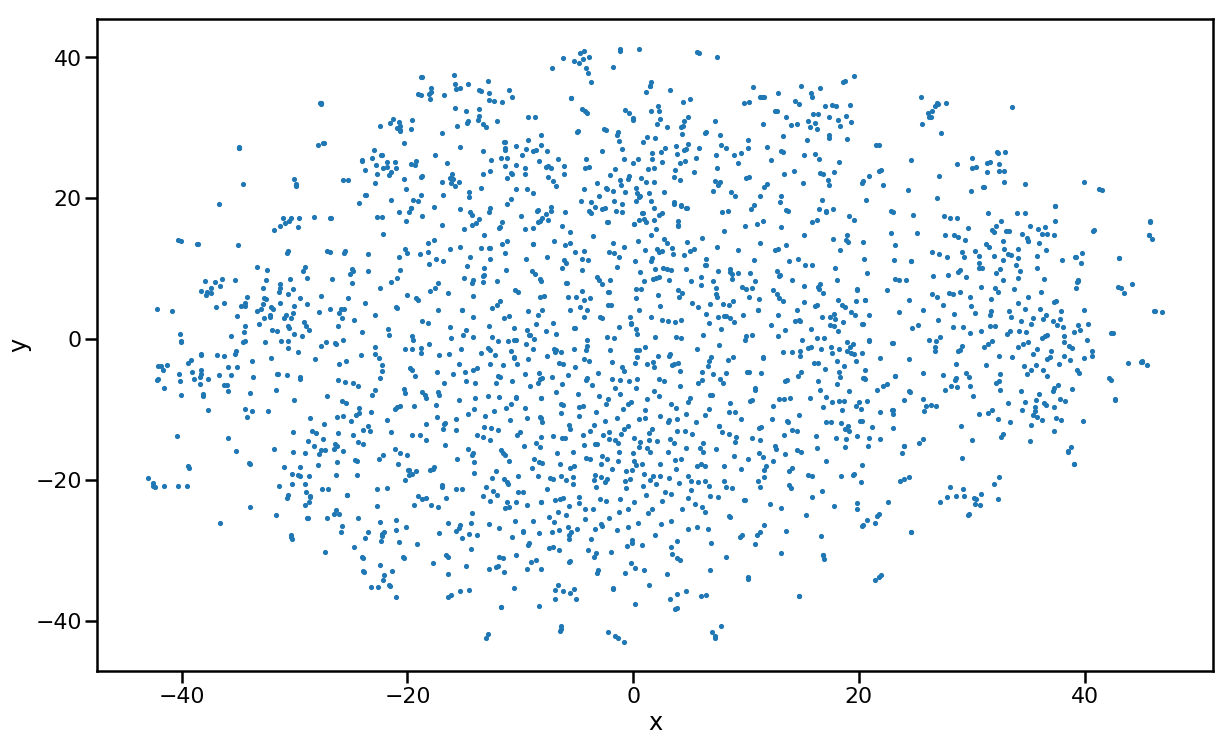

In [279]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

## More zoomed in visualization

In [280]:
def plot_region(x_bounds, y_bounds):
    slice = points[(points['x']>=x_bounds[0]) & (points['x']<=x_bounds[1]) & (points['y']>=y_bounds[0]) & (points['y']<=y_bounds[1]) ]
    #slice = points[(points['x']>=x_bounds[0]) & (points['x']<=x_bounds[1])]
    #print(slice)
    if not slice.empty:
        ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
        for i, point in slice.iterrows():
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
        

In [281]:
points[points['word']=='language']

,word,x,y
231,language,7.289802,-42.481464


From the follwoing plot we can see that the words related with food and taste came together. Words like Shiro, Bhakri, Onion, Garlic, Sweet, Spicy, Mango, Mutton, Puri, etc.

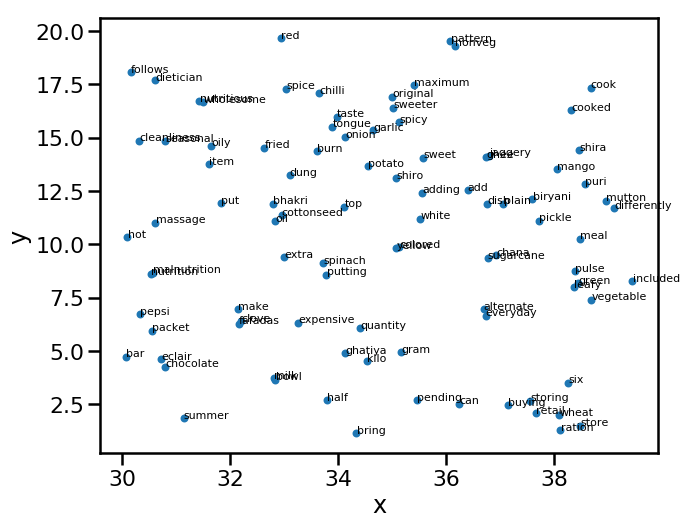

In [97]:
plot_region(x_bounds=(30,40), y_bounds=(0, 20))

From the follwoing plot we can see that the words exercise, yoga, Surya Namaskar, Pranayam, physical, laziness,etc. came together.

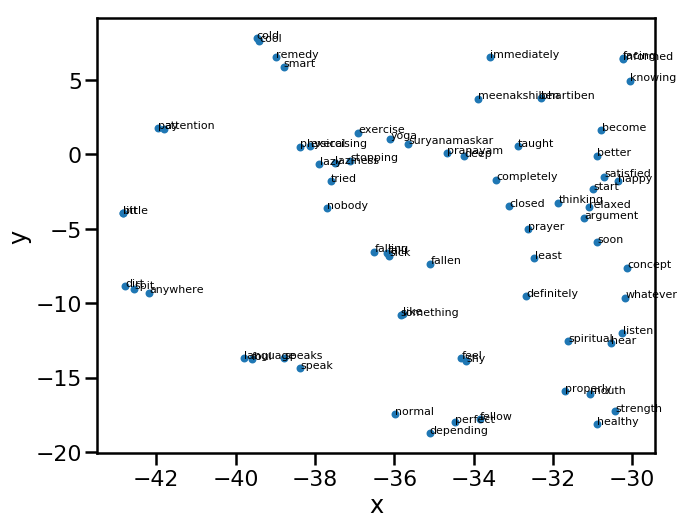

In [110]:
plot_region(x_bounds=(-50,-30), y_bounds=(-19, 8))

## Confirming the results obtained with Text Summarization Using Ranking:

In [75]:
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

<b>Checking what all fuels are used for cooking by drilling into the text data:

In [30]:
text=[]
temp=data[data['Data_clean'].str.contains('fuel')] 
for each in temp['Answer']:
    text.append(str(each))

In [32]:
parser = PlaintextParser.from_string(' '.join(text),Tokenizer("english"))

In [41]:
summarizer=LexRankSummarizer()
summary= summarizer(parser.document,5)
for s in summary:
    print(s)

They use gas and Chula Many use primus, many use Chula and now a days in many houses gas connection has also come.
They also use kerosene, as they get kerosene using their BPL card.
Those who don’t get kerosene will use Chula also.
They bring wood pieces and cook on Chula.
Gas cylinder.


<b>The result provided by Word2Vec is as follows. It confirms with the summary text obtained, also it povides little more information like sigdi.

In [267]:
response2vec.most_similar("fuel")

C:\Users\mpfou\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('primus', 0.9716500639915466),
 ('chula', 0.9446691274642944),
 ('lpg', 0.9272397756576538),
 ('kerosene', 0.9151356220245361),
 ('sigdi', 0.895534873008728),
 ('piece', 0.8855994939804077),
 ('winter', 0.8605989813804626),
 ('gas', 0.8334647417068481),
 ('cylinder', 0.7889919281005859),
 ('plain', 0.7841489315032959)]

<b>Checking what all work are done by the people there:
    
   When we tried to obtain the information about the work the community people are doing, through text summarization, it was not providing any useful results.

In [76]:
text=[]
temp=data[data['Answer'].str.contains('work')] 
for each in temp['Answer']:
    text.append(str(each))

In [77]:
parser = PlaintextParser.from_string(' '.join(text),Tokenizer("english"))

In [78]:
summarizer=LexRankSummarizer()
summary= summarizer(parser.document,5)
for s in summary:
    print(s)

In that also they have work.
If they have some work, then they will do.
They will say like there are work and so you do the work.
So they also have to go for that.
Some may go to their village if they want to do so and if there is any other work to be done, they would do that also.


<b>The result provided by Word2Vec is as follows. The above summarisation is not providing anything relevant. But the Word2Vec is giving an idea about the work that is being done by the community people.

In [59]:
response2vec.most_similar("work")

C:\Users\mpfou\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bungalow', 0.6556487083435059),
 ('mason', 0.6349966526031494),
 ('masonry', 0.6130069494247437),
 ('maid', 0.6075021624565125),
 ('construction', 0.6050369739532471),
 ('electrical', 0.6028178930282593),
 ('selfemployment', 0.5999700427055359),
 ('ride', 0.5870542526245117),
 ('floor', 0.5800060629844666),
 ('contract', 0.5795734524726868)]